# Systematic Filament Analysis Plots

This notebook generates a consistent set of plots for galaxy pair separations of 5, 10, and 20 Mpc/h.

For each separation, we produce:
1. Single galaxy stacked κ map (control, same for all)
2. Pair-stacked κ map (reflection symmetrized)
3. Control pair map (shifted single-galaxy map)
4. Filament map = (2) - (3)
5. Signal-to-noise map of (4)

All maps use consistent X/Y scales (-50, 50) Mpc/h and matching color scales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings('ignore')

# Grid parameters
box_size_hmpc = 100.0  # Mpc/h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box = box_size_hmpc / 2
extent = [-half_box, half_box, -half_box, half_box]

# Separations to analyze
separations = [5, 10, 20]

## Helper Functions

In [2]:
def reflect_symmetrize_y_axis(kappa_map):
    """
    Enforce reflection symmetry across the Y axis (left/right mirror):
    average (+x, y) with (-x, y).
    """
    h, w = kappa_map.shape
    c = w // 2  # center column
    sym = kappa_map.copy()
    
    # Average left half with flipped right half
    left = kappa_map[:, :c+1]
    right = np.fliplr(kappa_map)[:, :c+1]
    avg = 0.5 * (left + right)
    
    # Apply to both sides
    sym[:, :c+1] = avg
    sym[:, c:] = np.fliplr(avg)
    return sym


def create_control_pair_map(single_galaxy_map, separation):
    """
    Create control pair map by shifting single-galaxy map ±(separation/2) along X-axis.
    """
    shift_hmpc = separation / 2
    shift_pix = int(np.round(shift_hmpc / cell_size_hmpc))
    
    # Shift left and right, then sum
    map_left = np.roll(single_galaxy_map, -shift_pix, axis=1)
    map_right = np.roll(single_galaxy_map, +shift_pix, axis=1)
    
    return map_left + map_right


def compute_snr_map(signal_map, error_map):
    """
    Compute signal-to-noise ratio map.
    """
    snr = np.zeros_like(signal_map)
    valid = error_map > 0
    snr[valid] = signal_map[valid] / error_map[valid]
    return snr

## Load Data Files

Adjust file paths as needed based on your data directory structure.

In [3]:
# --- Load single galaxy control map (same for all separations) ---
# This should be from ALL CMASS galaxies, not just pair catalog galaxies
try:
    single_galaxy_map = pd.read_csv("data/kappa_control_original_BOSS_North.csv", index_col=0).values
    print(f"Loaded single galaxy control map: shape {single_galaxy_map.shape}")
except FileNotFoundError:
    print("WARNING: kappa_control_original_BOSS_North.csv not found.")
    print("Please run finalMODkmap.ipynb first to generate the control map from ALL CMASS galaxies.")
    single_galaxy_map = None

# --- Load error map for S/N calculation ---
try:
    error_map = pd.read_csv("data/error_map_BOSS_N.csv", index_col=0).values
    print(f"Loaded error map: shape {error_map.shape}")
except FileNotFoundError:
    print("WARNING: error_map_BOSS_N.csv not found. S/N maps will not be computed.")
    error_map = None

Loaded single galaxy control map: shape (100, 100)
Loaded error map: shape (100, 100)


In [4]:
# --- Load pair-stacked maps for each separation ---
pair_maps = {}

for sep in separations:
    # Try BOSS naming convention first, then eBOSS
    filenames = [
        f"data/kappa_sym_{sep}_BOSS_NGCSGC.csv",
        f"data/kappa_sym_{sep}_eBOSS_NGCSGC.csv",
        f"data/kappa_sym_{sep}hmpc_NGCSGC.csv",
    ]
    
    loaded = False
    for fname in filenames:
        try:
            pair_maps[sep] = pd.read_csv(fname, index_col=0).values
            print(f"Loaded {sep} Mpc/h pair map from {fname}: shape {pair_maps[sep].shape}")
            loaded = True
            break
        except FileNotFoundError:
            continue
    
    if not loaded:
        print(f"WARNING: No pair map found for {sep} Mpc/h separation")
        pair_maps[sep] = None

print(f"\nLoaded pair maps for separations: {[s for s in separations if pair_maps.get(s) is not None]}")

Loaded 5 Mpc/h pair map from data/kappa_sym_5_BOSS_NGCSGC.csv: shape (101, 101)
Loaded 10 Mpc/h pair map from data/kappa_sym_10_BOSS_NGCSGC.csv: shape (101, 101)
Loaded 20 Mpc/h pair map from data/kappa_sym_20_BOSS_NGCSGC.csv: shape (101, 101)

Loaded pair maps for separations: [5, 10, 20]


## Compute Derived Maps

In [5]:
# --- Compute control, filament, and S/N maps for each separation ---
control_maps = {}
filament_maps = {}
snr_maps = {}

if single_galaxy_map is not None:
    for sep in separations:
        # Create control pair map
        control_maps[sep] = create_control_pair_map(single_galaxy_map, sep)
        
        # Compute filament map if pair map exists
        if pair_maps.get(sep) is not None:
            # Ensure same shape
            min_size = min(pair_maps[sep].shape[0], control_maps[sep].shape[0])
            signal = pair_maps[sep][:min_size, :min_size]
            control = control_maps[sep][:min_size, :min_size]
            
            filament_maps[sep] = signal - control
            
            # Compute S/N if error map available
            if error_map is not None:
                err = error_map[:min_size, :min_size]
                snr_maps[sep] = compute_snr_map(filament_maps[sep], err)
            
            print(f"{sep} Mpc/h: Computed filament map, range [{filament_maps[sep].min():.6f}, {filament_maps[sep].max():.6f}]")
else:
    print("Cannot compute derived maps without single galaxy control map.")

5 Mpc/h: Computed filament map, range [-0.001956, 0.001738]
10 Mpc/h: Computed filament map, range [-0.001845, 0.003204]
20 Mpc/h: Computed filament map, range [-0.001158, 0.000963]


## Determine Consistent Color Scales

In [6]:
# --- Determine global vmin/vmax for consistent color scales ---

# For pair maps (2)
pair_vals = [pair_maps[s] for s in separations if pair_maps.get(s) is not None]
if pair_vals:
    pair_vmin = min(m.min() for m in pair_vals)
    pair_vmax = max(m.max() for m in pair_vals)
    print(f"Pair maps range: [{pair_vmin:.6f}, {pair_vmax:.6f}]")

# For control maps (3)
ctrl_vals = [control_maps[s] for s in separations if s in control_maps]
if ctrl_vals:
    ctrl_vmin = min(m.min() for m in ctrl_vals)
    ctrl_vmax = max(m.max() for m in ctrl_vals)
    print(f"Control maps range: [{ctrl_vmin:.6f}, {ctrl_vmax:.6f}]")

# For filament maps (4)
fil_vals = [filament_maps[s] for s in separations if s in filament_maps]
if fil_vals:
    fil_vmin = min(m.min() for m in fil_vals)
    fil_vmax = max(m.max() for m in fil_vals)
    fil_vmax_low = fil_vmax * 0.5  # Lower vmax for enhanced contrast
    print(f"Filament maps range: [{fil_vmin:.6f}, {fil_vmax:.6f}]")
    print(f"Filament maps (low vmax): [{fil_vmin:.6f}, {fil_vmax_low:.6f}]")

# For S/N maps (5)
snr_vals = [snr_maps[s] for s in separations if s in snr_maps]
if snr_vals:
    snr_vmin = min(m.min() for m in snr_vals)
    snr_vmax = max(m.max() for m in snr_vals)
    # Symmetric range for diverging colormap
    snr_abs_max = max(abs(snr_vmin), abs(snr_vmax))
    print(f"S/N maps range: [{snr_vmin:.2f}, {snr_vmax:.2f}] (symmetric: ±{snr_abs_max:.2f})")

# Combined range for maps (2)-(4) for direct comparison
all_kappa = pair_vals + ctrl_vals
if all_kappa:
    combined_vmin = min(m.min() for m in all_kappa)
    combined_vmax = max(m.max() for m in all_kappa)
    print(f"\nCombined κ range for (2)-(3): [{combined_vmin:.6f}, {combined_vmax:.6f}]")

Pair maps range: [-0.001494, 0.008820]
Control maps range: [-0.000542, 0.008035]
Filament maps range: [-0.001956, 0.003204]
Filament maps (low vmax): [-0.001956, 0.001602]
S/N maps range: [-2.99, 4.44] (symmetric: ±4.44)

Combined κ range for (2)-(3): [-0.001494, 0.008820]


## Plot 1: Single Galaxy Control Map (Same for All Separations)

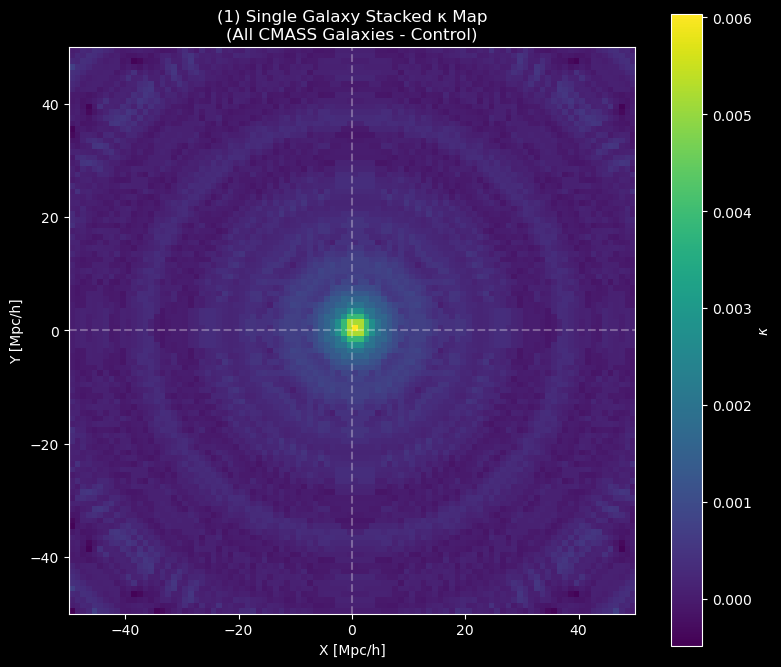

In [7]:
if single_galaxy_map is not None:
    fig, ax = plt.subplots(figsize=(8, 7))
    
    im = ax.imshow(single_galaxy_map, origin='lower', extent=extent, cmap='viridis')
    cbar = plt.colorbar(im, ax=ax, label=r'$\kappa$')
    
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_title('(1) Single Galaxy Stacked κ Map\n(All CMASS Galaxies - Control)')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.axhline(0, color='white', linestyle='--', alpha=0.3)
    ax.axvline(0, color='white', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/01_single_galaxy_control.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Single galaxy map not available.")

## Plots 2-5: Systematic Sequence for Each Separation

In [8]:
def plot_sequence_for_separation(sep, pair_map, control_map, filament_map, snr_map,
                                  combined_vmin, combined_vmax, fil_vmax_low, snr_abs_max):
    """
    Plot the full sequence (2)-(5) for a given separation.
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 11))
    
    # (2) Pair-stacked κ map (reflection symmetrized)
    ax = axes[0, 0]
    if pair_map is not None:
        im = ax.imshow(pair_map, origin='lower', extent=extent, cmap='viridis',
                       vmin=combined_vmin, vmax=combined_vmax)
        plt.colorbar(im, ax=ax, label=r'$\kappa$')
        ax.set_title(f'(2) Pair-Stacked κ Map\n{sep} Mpc/h (Reflection Sym.)')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'(2) Pair-Stacked κ Map\n{sep} Mpc/h')
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    
    # (3) Control pair map
    ax = axes[0, 1]
    if control_map is not None:
        im = ax.imshow(control_map, origin='lower', extent=extent, cmap='viridis',
                       vmin=combined_vmin, vmax=combined_vmax)
        plt.colorbar(im, ax=ax, label=r'$\kappa$')
        ax.set_title(f'(3) Control Pair Map\n±{sep/2:.1f} Mpc/h shifted')
        # Mark expected peak positions
        ax.axvline(-sep/2, color='red', linestyle='--', alpha=0.5, label=f'-{sep/2} Mpc/h')
        ax.axvline(+sep/2, color='red', linestyle='--', alpha=0.5, label=f'+{sep/2} Mpc/h')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'(3) Control Pair Map')
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    
    # (4a) Filament map (normal scale)
    ax = axes[0, 2]
    if filament_map is not None:
        im = ax.imshow(filament_map, origin='lower', extent=extent, cmap='RdBu_r',
                       vmin=-max(abs(filament_map.min()), abs(filament_map.max())),
                       vmax=max(abs(filament_map.min()), abs(filament_map.max())))
        plt.colorbar(im, ax=ax, label=r'$\Delta\kappa$')
        ax.set_title(f'(4a) Filament Map (Signal - Control)\n{sep} Mpc/h')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'(4a) Filament Map')
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    
    # (4b) Filament map (low vmax for enhanced contrast)
    ax = axes[1, 0]
    if filament_map is not None:
        vmax_enhanced = fil_vmax_low if fil_vmax_low > 0 else filament_map.max() * 0.5
        im = ax.imshow(filament_map, origin='lower', extent=extent, cmap='RdBu_r',
                       vmin=-vmax_enhanced, vmax=vmax_enhanced)
        plt.colorbar(im, ax=ax, label=r'$\Delta\kappa$')
        ax.set_title(f'(4b) Filament Map (Low vmax)\n{sep} Mpc/h')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'(4b) Filament Map (Low vmax)')
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    
    # (5) Signal-to-noise map
    ax = axes[1, 1]
    if snr_map is not None:
        im = ax.imshow(snr_map, origin='lower', extent=extent, cmap='coolwarm',
                       vmin=-snr_abs_max, vmax=snr_abs_max)
        plt.colorbar(im, ax=ax, label='S/N')
        ax.set_title(f'(5) Signal-to-Noise Map\n{sep} Mpc/h')
    else:
        ax.text(0.5, 0.5, 'No S/N data\n(error map needed)', ha='center', va='center', 
                transform=ax.transAxes)
        ax.set_title(f'(5) Signal-to-Noise Map')
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    
    # Hide unused subplot
    axes[1, 2].axis('off')
    
    # Add text summary
    axes[1, 2].text(0.1, 0.8, f'Summary for {sep} Mpc/h:', fontsize=12, fontweight='bold',
                    transform=axes[1, 2].transAxes)
    if pair_map is not None:
        axes[1, 2].text(0.1, 0.65, f'Pair map range: [{pair_map.min():.2e}, {pair_map.max():.2e}]',
                        fontsize=10, transform=axes[1, 2].transAxes)
    if filament_map is not None:
        axes[1, 2].text(0.1, 0.50, f'Filament range: [{filament_map.min():.2e}, {filament_map.max():.2e}]',
                        fontsize=10, transform=axes[1, 2].transAxes)
    if snr_map is not None:
        axes[1, 2].text(0.1, 0.35, f'S/N range: [{snr_map.min():.2f}, {snr_map.max():.2f}]',
                        fontsize=10, transform=axes[1, 2].transAxes)
    
    plt.suptitle(f'Filament Analysis: {sep} Mpc/h Pair Separation', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    return fig


Generating plots for 5 Mpc/h separation


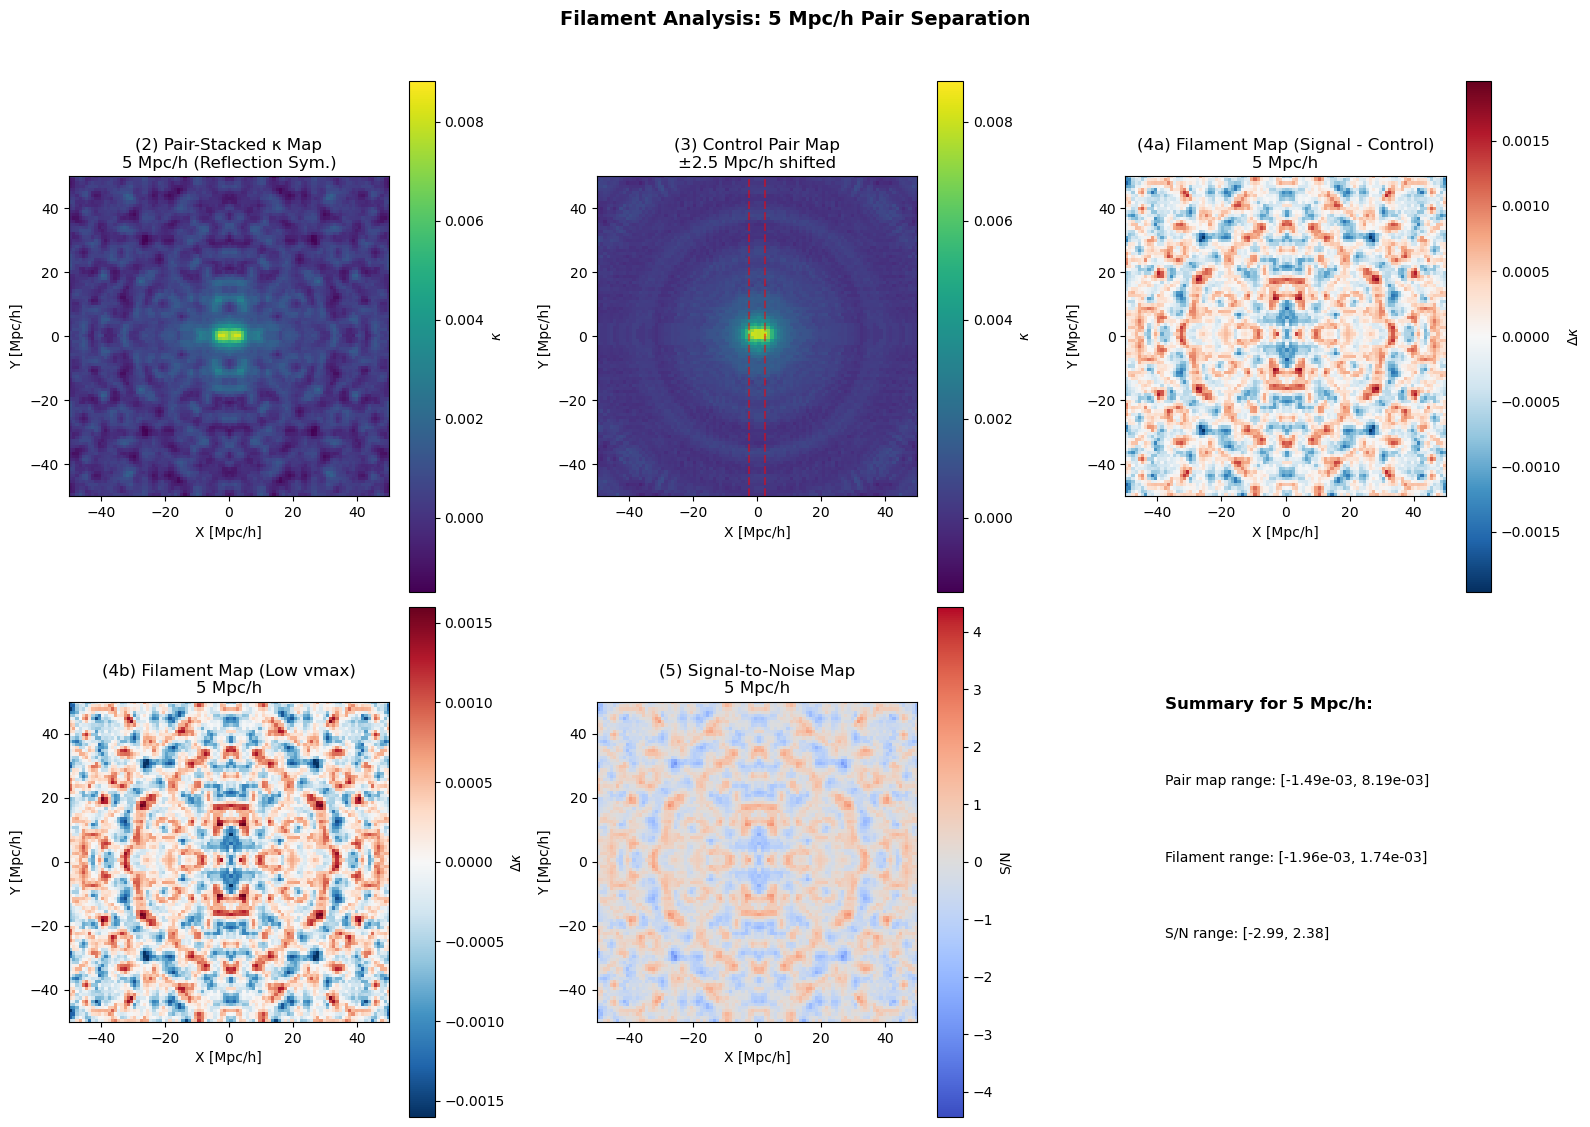


Generating plots for 10 Mpc/h separation


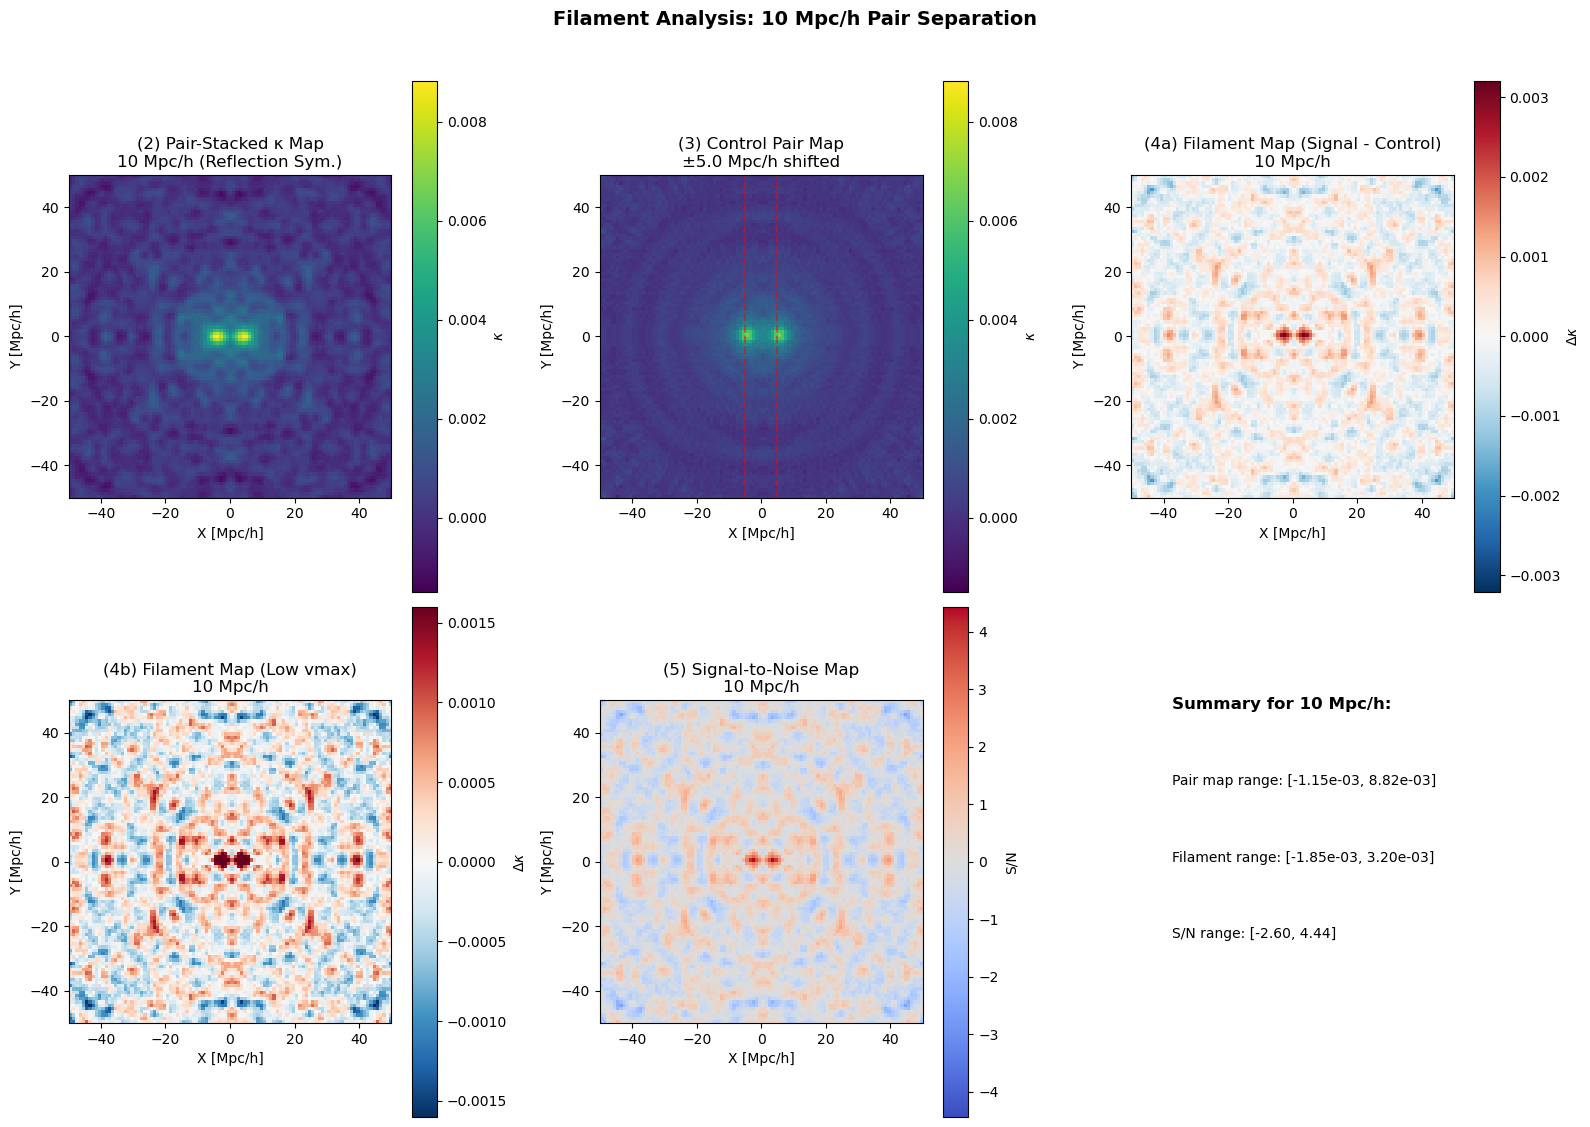


Generating plots for 20 Mpc/h separation


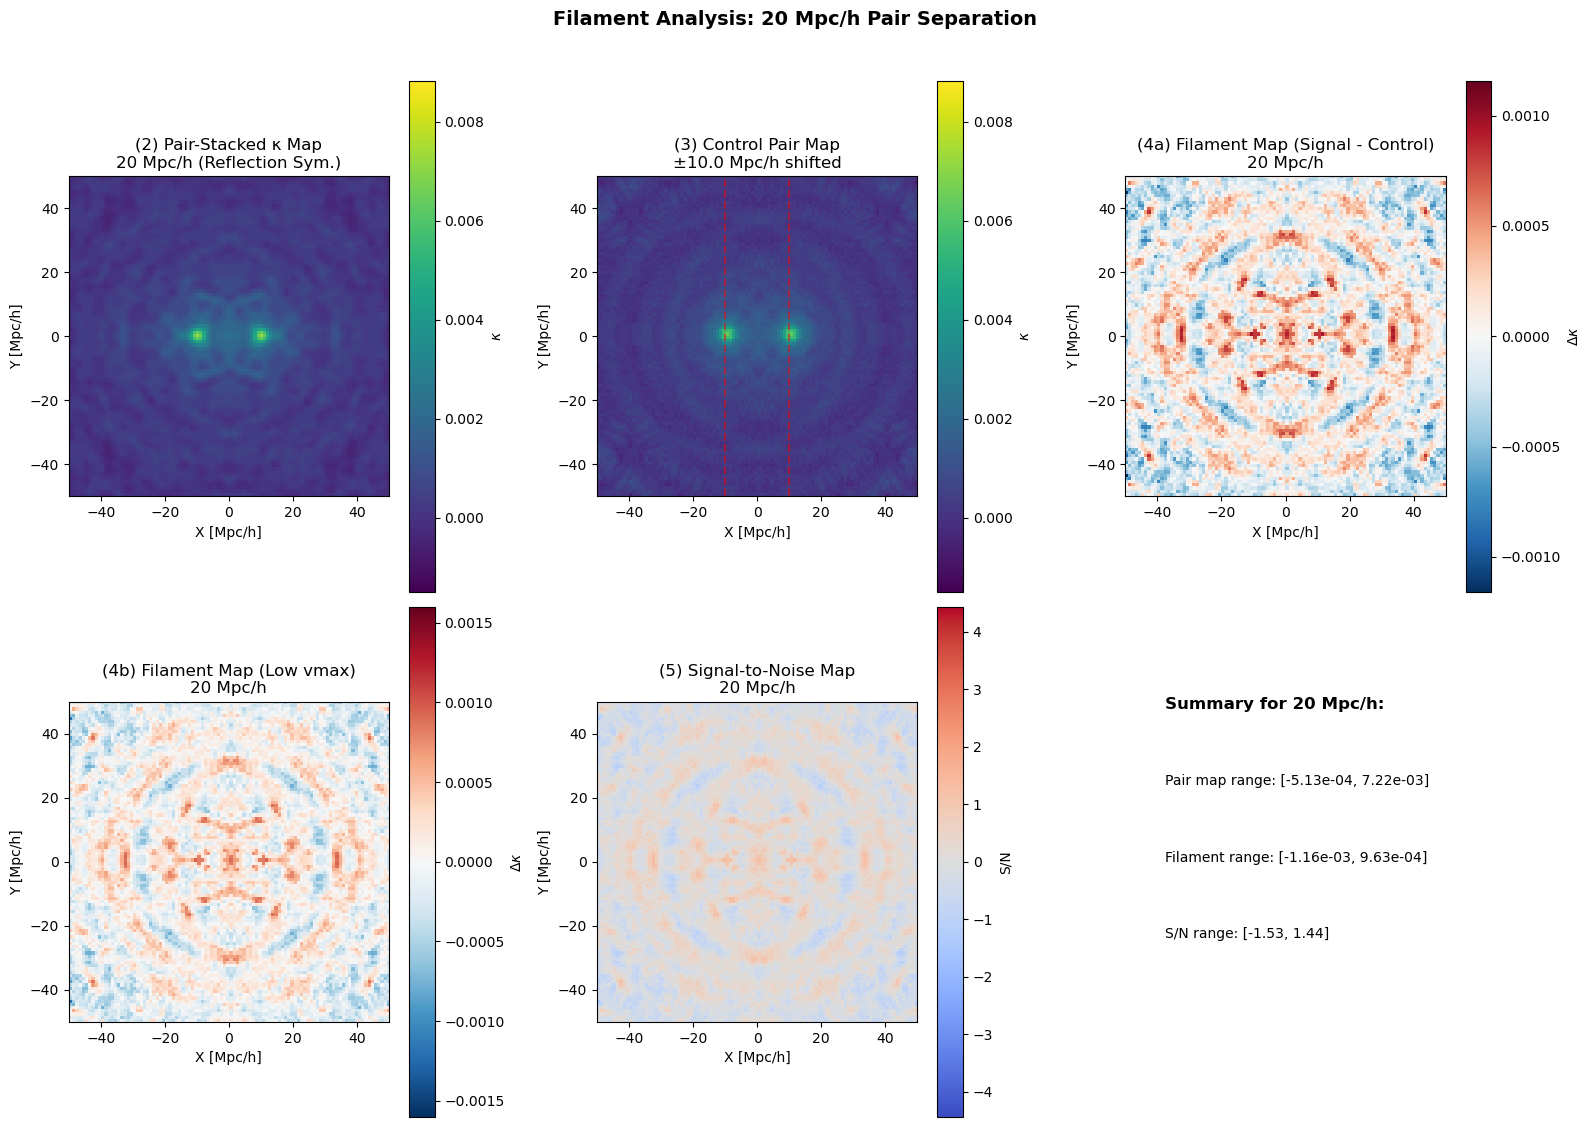


All plots saved to 'plots/' directory.


In [10]:
# Create plots directory if it doesn't exist
import os
os.makedirs('plots', exist_ok=True)

# Generate plots for each separation
for sep in separations:
    print(f"\n{'='*60}")
    print(f"Generating plots for {sep} Mpc/h separation")
    print(f"{'='*60}")
    
    fig = plot_sequence_for_separation(
        sep=sep,
        pair_map=pair_maps.get(sep),
        control_map=control_maps.get(sep),
        filament_map=filament_maps.get(sep),
        snr_map=snr_maps.get(sep),
        combined_vmin=combined_vmin if 'combined_vmin' in dir() else 0,
        combined_vmax=combined_vmax if 'combined_vmax' in dir() else 0.01,
        fil_vmax_low=fil_vmax_low if 'fil_vmax_low' in dir() else 0.001,
        snr_abs_max=snr_abs_max if 'snr_abs_max' in dir() else 5
    )
    
    plt.savefig(f'plots/filament_analysis_{sep}mpc.png', dpi=150, bbox_inches='tight')
    plt.show()
    
print("\nAll plots saved to 'plots/' directory.")

## Side-by-Side Comparison Across All Separations

In [ ]:
# Create a comparison figure with all separations side by side
fig, axes = plt.subplots(4, 3, figsize=(15, 18))

row_titles = ['(2) Pair-Stacked κ', '(3) Control Pair', '(4) Filament', '(5) S/N']

for col, sep in enumerate(separations):
    # Row 0: Pair maps
    ax = axes[0, col]
    if pair_maps.get(sep) is not None:
        im = ax.imshow(pair_maps[sep], origin='lower', extent=extent, cmap='viridis',
                       vmin=combined_vmin, vmax=combined_vmax)
    ax.set_title(f'{sep} Mpc/h')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    if col == 0:
        ax.set_ylabel(row_titles[0])
    
    # Row 1: Control maps
    ax = axes[1, col]
    if control_maps.get(sep) is not None:
        im = ax.imshow(control_maps[sep], origin='lower', extent=extent, cmap='viridis',
                       vmin=combined_vmin, vmax=combined_vmax)
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    if col == 0:
        ax.set_ylabel(row_titles[1])
    
    # Row 2: Filament maps
    ax = axes[2, col]
    if filament_maps.get(sep) is not None:
        vabs = max(abs(filament_maps[sep].min()), abs(filament_maps[sep].max()))
        im = ax.imshow(filament_maps[sep], origin='lower', extent=extent, cmap='RdBu_r',
                       vmin=-vabs, vmax=vabs)
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    if col == 0:
        ax.set_ylabel(row_titles[2])
    
    # Row 3: S/N maps
    ax = axes[3, col]
    if snr_maps.get(sep) is not None:
        im = ax.imshow(snr_maps[sep], origin='lower', extent=extent, cmap='coolwarm',
                       vmin=-snr_abs_max, vmax=snr_abs_max)
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.set_xlabel('X [Mpc/h]')
    if col == 0:
        ax.set_ylabel(row_titles[3])

plt.suptitle('Comparison Across All Separations', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('plots/comparison_all_separations.png', dpi=150, bbox_inches='tight')
plt.show()

## Notes

### Data Requirements
- Single galaxy control map: Should be generated from ALL CMASS galaxies (use `finalMODkmap.ipynb`)
- Pair-stacked maps: Should use reflection symmetry only (not rotational)
- Error map: Needed for S/N calculation (from jackknife resampling)

### Color Scale Conventions
- Maps (2) and (3) use the same color scale for direct comparison
- Map (4) uses a diverging colormap (RdBu_r) centered at zero
- Map (5) uses a symmetric diverging colormap for S/N

### File Naming
Expected input files:
- `data/kappa_control_original_BOSS_North.csv` - Single galaxy control
- `data/kappa_sym_{sep}_BOSS_NGCSGC.csv` - Pair-stacked maps
- `data/error_map_BOSS_N.csv` - Error map for S/N